In [1]:

import numpy as np
import pandas as pd

from DataAnalysisClass import *
from clustering_work import *
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

single = ['aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ', 'aug-cc-pV5Z', 'aug-cc-pV6Z']
single_polarized = ['aug-cc-pCVDZ', 'aug-cc-pCVTZ', 'aug-cc-pCVQZ']
double = ['d-aug-cc-pVDZ', 'd-aug-cc-pVTZ', 'd-aug-cc-pVQZ', 'd-aug-cc-pV5Z', 'd-aug-cc-pV6Z']
double_polarized = ['d-aug-cc-pCVDZ', 'd-aug-cc-pCVTZ', 'd-aug-cc-pCVQZ']
all_basis_sets = single + single_polarized + double + double_polarized


In [2]:
csv_path = Path("csv")
csv_path.mkdir(exist_ok=True)
beta_hrs_error_path=csv_path.joinpath('beta_hrs_error.csv')
beta_para_error_path=csv_path.joinpath('beta_parallel_error.csv')
beta_hrs_path=csv_path.joinpath('beta_hrs.csv')
beta_para_path=csv_path.joinpath('beta_parallel.csv')
beta_path=csv_path.joinpath('beta_ijk.csv')


In [3]:

paper_path = Path('beta_figures')



In [4]:
#read first column as index 
beta_hrs=pd.read_csv(beta_hrs_path, index_col=0)
beta_df=pd.read_csv(beta_path, index_col=0)
# glob for .mol files in august molecules directory


In [5]:
beta_df

,Afreq,Bfreq,Cfreq,ijk,basis,molecule,Beta,a,b,c
0,0.0000,0.0000,0.0000,XXX,MRA,FNO,-5.899730,0,0,0
1,0.0000,0.0000,0.0000,XYY,MRA,FNO,-2.972730,0,0,0
2,0.0000,0.0000,0.0000,YXY,MRA,FNO,-2.972730,0,0,0
3,0.0000,0.0000,0.0000,YYX,MRA,FNO,-2.972730,0,0,0
4,0.0000,0.0000,0.0000,XYZ,MRA,FNO,-0.000220,0,0,0
...,...,...,...,...,...,...,...,...,...,...
655635,0.0974,0.0325,0.0649,YZZ,d-aug-cc-pCVQZ,LiBH4,-0.002181,6,2,4
655636,0.0974,0.0325,0.0649,ZZZ,d-aug-cc-pCVQZ,LiBH4,63.774400,6,2,4
655637,0.1136,0.0487,0.0649,XZZ,d-aug-cc-pCVQZ,LiBH4,-0.003208,7,3,4
655638,0.1136,0.0487,0.0649,YZZ,d-aug-cc-pCVQZ,LiBH4,-0.003026,7,3,4


In [6]:
# if Beta < threshold, set Beta to 0
thresh=1e-4
beta_df['Beta'] = beta_df['Beta'].apply(lambda x: 0 if np.abs(x) < thresh else x)

In [7]:
class MRAComparedBasisDF(pd.DataFrame):
    def __init__(self, polar_data, index, values: list, PercentError: bool, *args, **kwargs):
        # Use the special_parameter to modify the DataFrame or perform additional initialization
        basis_data = polar_data.query('basis!="MRA"').copy()
        basis_data = basis_data.set_index(index)

        for value in values:
            basis_data[f'{value}MRA'] = polar_data.query('basis=="MRA"').set_index(index)[
                value]
            if PercentError:
                basis_data[f'{value}E'] = ((basis_data[value] - basis_data[f'{value}MRA']) / basis_data[f'{value}MRA'] * 100)
            else:
                basis_data[f'{value}E'] = (basis_data[value] - basis_data[f'{value}MRA'])
        basis_data = basis_data.reset_index()
        # create a column of percent error in alpha
        basis_data = make_detailed_df(basis_data)
        super().__init__(basis_data, *args, **kwargs)

In [8]:
beta_basis_error_df=MRAComparedBasisDF(beta_df, index=['molecule','ijk','b','c',], values=['Beta' ], PercentError=True)

['D', 'T', 'Q', '5']


In [9]:
beta_hrs_error_df=pd.read_csv(beta_hrs_error_path, index_col=0)

In [10]:
beta_hrs_error_df

,b,c,molecule,basis,Beta,beta_MRA,betaE,augmentation,polarization,mol_system,valence,Type
0,0,0,BF,aug-cc-pCVDZ,25.115272,28.239003,-11.061760,aug,CV,Fluorine,D,aug-cc-pCVnZ
1,0,0,BH2Cl,aug-cc-pCVDZ,33.935421,21.951127,54.595344,aug,CV,Second-row,D,aug-cc-pCVnZ
2,0,0,BH2F,aug-cc-pCVDZ,25.310664,25.259990,0.200610,aug,CV,Fluorine,D,aug-cc-pCVnZ
3,0,0,BH3,aug-cc-pCVDZ,6.851658,6.652353,2.996004,aug,CV,First-row,D,aug-cc-pCVnZ
4,0,0,BHF2,aug-cc-pCVDZ,17.548499,16.937269,3.608793,aug,CV,Fluorine,D,aug-cc-pCVnZ
...,...,...,...,...,...,...,...,...,...,...,...,...
22178,4,4,NaCN,d-aug-cc-pVTZ,106.175031,98.883580,7.373773,d-aug,V,Second-row,T,d-aug-cc-pVnZ
22184,4,4,OF2,d-aug-cc-pVTZ,2.163086,2.155624,0.346171,d-aug,V,Fluorine,T,d-aug-cc-pVnZ
22187,4,4,PH3O,d-aug-cc-pVTZ,55.129263,70.860857,-22.200682,d-aug,V,Second-row,T,d-aug-cc-pVnZ
22192,4,4,SiH3Cl,d-aug-cc-pVTZ,33.140406,31.592541,4.899463,d-aug,V,Second-row,T,d-aug-cc-pVnZ


In [11]:
data_df=beta_hrs

basis_data=beta_hrs_error_df.copy()
mra_data=data_df.query('basis=="MRA"').copy()


In [12]:
sns.set_style('dark')
subset_mols=['SF2']
vlevel = ['D','T','Q','5']
basis_labels=['s-D','s-T','s-Q','s-5','s-CD','s-CT','s-CQ','d-D','d-T','d-Q','d-CD','d-CT','d-CQ','d-5']
omegas=[0,2,4,6,8]
plot_data = basis_data.query('valence.isin(@vlevel) and molecule.isin(@subset_mols) and omega.isin(@omegas)' ).copy()
# remove unused categories from valence
mra_plot_data = mra_data.query('molecule.isin(@subset_mols) and omega.isin(@omegas)').copy()

# create a figure with ax
fig, ax = plt.subplots(1, 1, figsize=(11, 6))

#sns.lineplot(data=mra_plot_data, x='omega', y='alpha',  markers=True, ax=ax, palette=['k'],size=30, legend=False)
# make a plotlib lineplot
import matplotlib.pyplot as plt
pal='magma'

# create a plot of basis vs alpha
sns.lineplot(data=plot_data, x='basis', y='alpha', markers=True, ax=ax,legend='brief',hue='a',palette=pal,linewidth=1)
sns.scatterplot(data=plot_data, x='basis', y='alpha', ax=ax, hue='a',palette=pal,legend=False)
# rotate xlabels
plt.xticks(rotation=45)

# move the legend to the right off the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Frequency')

# replace the xticks with basis labels
ax.set_xticklabels(basis_labels)

# set the title
ax.set_title('{} '.format(subset_mols[0]))
# set the ylabel
ax.set_ylabel('Polarizability')
# set the xlabel
ax.set_xlabel('')


mra_colors=sns.color_palette(pal, n_colors=len(omegas))

for i,om in enumerate(omegas):
    mra_om=mra_plot_data.query('a==@om')
    plt.axhline(mra_om.alpha.iloc[0], color=mra_colors[i], linestyle='--', label='MRA')

# make background face lighter 
#ax.set_facecolor('grey')

# change the alpha of the background face
ax.patch.set_alpha(0.3)




UndefinedVariableError: name 'omega' is not defined

In [16]:
mol='HF'
plot_data=basis_data.query('molecule==@mol and b==c').copy()
plot_data['omega']=plot_data['b']
o=plot_data.omega.unique()
mra=plot_data.beta_MRA.unique()
mra_data=pd.DataFrame({'omega':o, 'beta_MRA':mra})



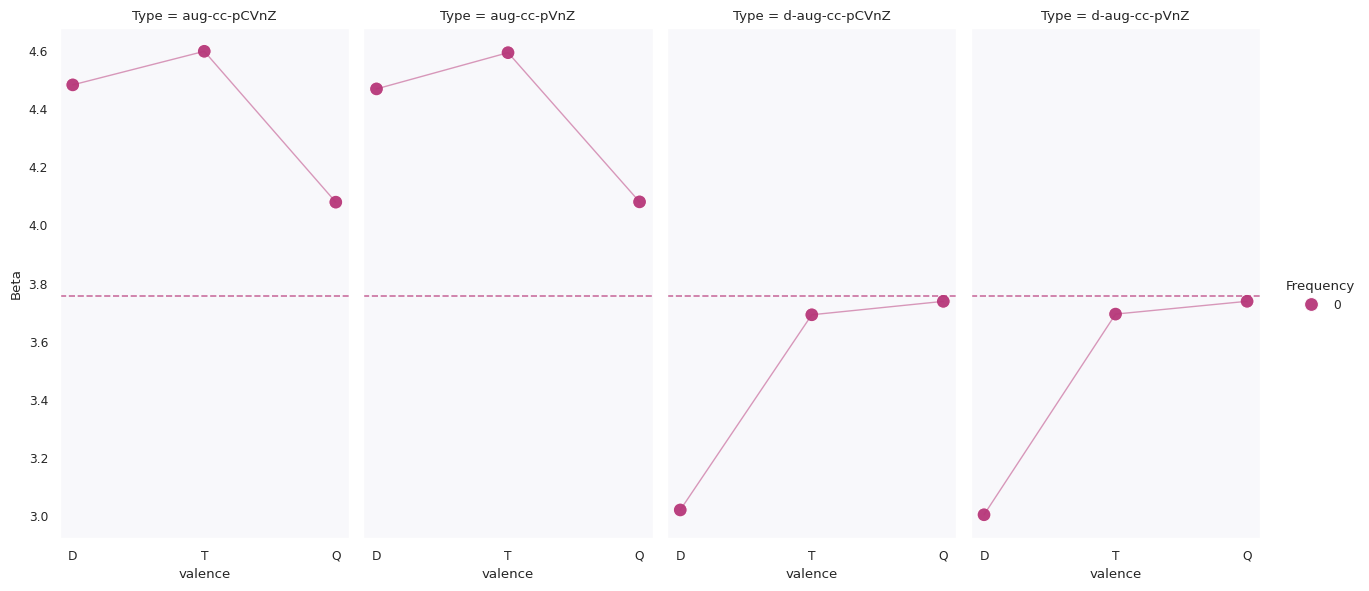

In [44]:
pal='magma'
vlevel = ['D','T','Q',]
omegas=plot_data.omega.unique()

# sort plot data by vlevel
plot_data.valence = plot_data.valence.astype('category')
# panbdas category valence order by vlevel
plot_data.valence = plot_data.valence.cat.reorder_categories(vlevel, ordered=True)
plot_data.omega=plot_data.omega.astype('category')
plot_data.omega = plot_data.omega.cat.remove_unused_categories()


# create an omega column 
g = sns.FacetGrid(data=plot_data, col='Type', sharey=True, sharex=False, height=6,aspect=.5, despine=False)
g.map_dataframe(sns.lineplot, x='valence', y='Beta', hue='omega',  alpha=.5, palette=pal,lw=1,
                legend=True)
g.map_dataframe(sns.scatterplot, x='valence', y='Beta', hue='omega',  alpha=.95, palette=pal,s=100 )

mra_colors=sns.color_palette(pal, n_colors=len(omegas))
for ax in g.axes.flat:
    for i,om in enumerate(omegas):
        mra_om=mra_data.query('omega==@om')
        ax.axhline(mra_om.beta_MRA.iloc[0], color=mra_colors[i], linestyle='--', label='MRA',alpha=.7)
    ax.patch.set_alpha(0.3)

g.add_legend(title='Frequency', loc='center left', bbox_to_anchor=(1, 0.5))

g.figure.tight_layout()

# create a function to plot the data by molecule


    



In [52]:

def plot_basis_molecule_convergence(df,mol,vlevel):
    plot_data=df.query('molecule==@mol and b==c and valence.isin(@vlevel)' ).copy()
    plot_data['omega']=plot_data['b']
    o=plot_data.omega.unique()
    mra=plot_data.beta_MRA.unique()
    mra_data=pd.DataFrame({'omega':o, 'beta_MRA':mra})
    
    pal='magma'
    plot_data.valence = plot_data.valence.astype('category')
    plot_data.valence = plot_data.valence.cat.remove_unused_categories()
    vlevel=list(plot_data.valence.unique())
    plot_data.valence = plot_data.valence.cat.reorder_categories(vlevel, ordered=True)
    plot_data.omega=plot_data.omega.astype('category')
    plot_data.omega = plot_data.omega.cat.remove_unused_categories()
    
    type_order=['aug-cc-pVnZ','aug-cc-pCVnZ','d-aug-cc-pVnZ','d-aug-cc-pCVnZ']


    # create an omega column 
    g = sns.FacetGrid(data=plot_data, col='Type', col_order=type_order, sharey=True, sharex=False, height=6,aspect=.5, despine=False)
    g.map_dataframe(sns.lineplot, x='valence', y='Beta', hue='omega',  alpha=.5, palette=pal,lw=1,
                    legend=True)
    g.map_dataframe(sns.scatterplot, x='valence', y='Beta', hue='omega',  alpha=.95, palette=pal,s=100 )

    mra_colors=sns.color_palette(pal, n_colors=len(o))
    for ax in g.axes.flat:
        for i,beta in enumerate(mra_data.beta_MRA):
            ax.axhline(beta, color=mra_colors[i], linestyle='--', label='MRA',alpha=.7)
        ax.patch.set_alpha(0.3)

    g.add_legend(title='Frequency', loc='center left', bbox_to_anchor=(1, 0.5))

    g.figure.tight_layout()
    return g


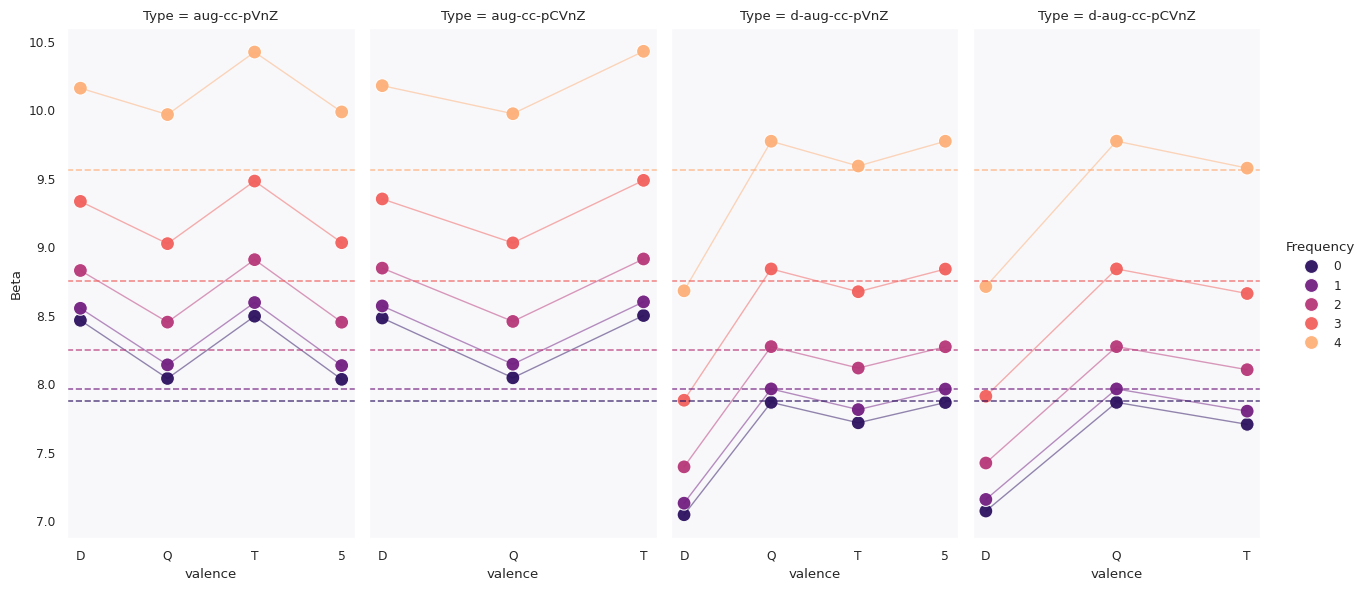

In [55]:
# These values are plotted at values where beta == c therefore the outgoing frequency is 2*omega
plot_basis_molecule_convergence(beta_hrs_error_df,'H2O',['D','T','Q','5'])

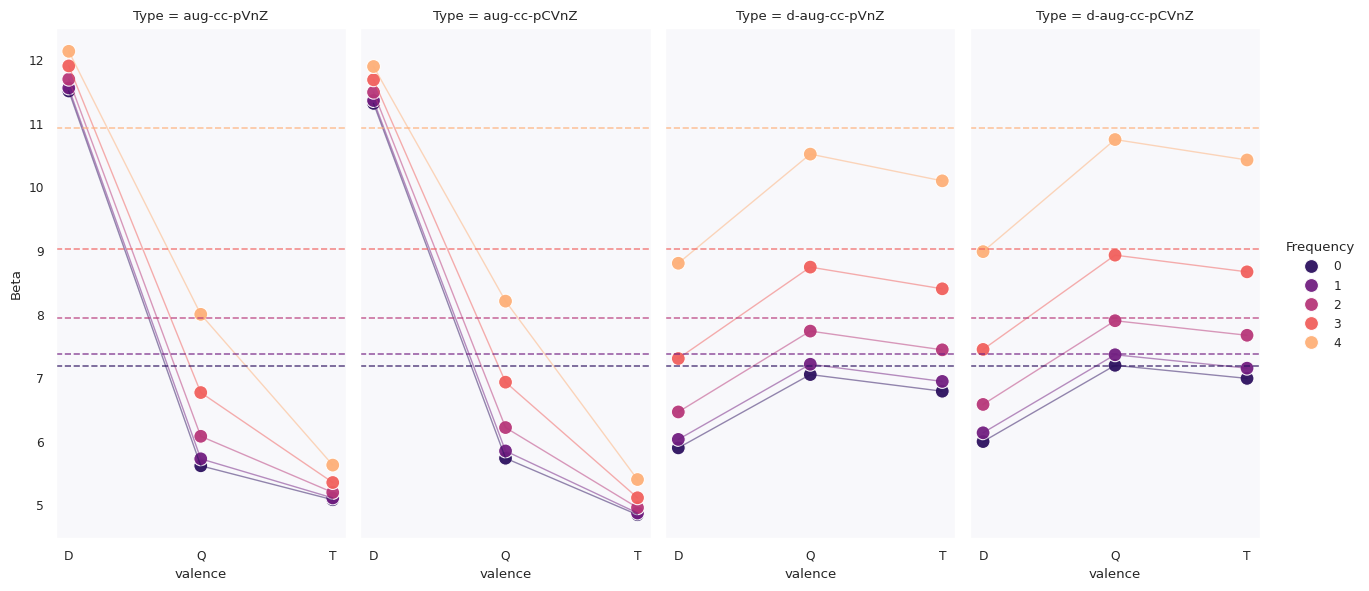

In [54]:
beta_hrs_error_df.query('molecule=="HCl"').query('b==c')
plot_basis_molecule_convergence(beta_hrs_error_df,'CH3Cl',['D','T','Q','5'])


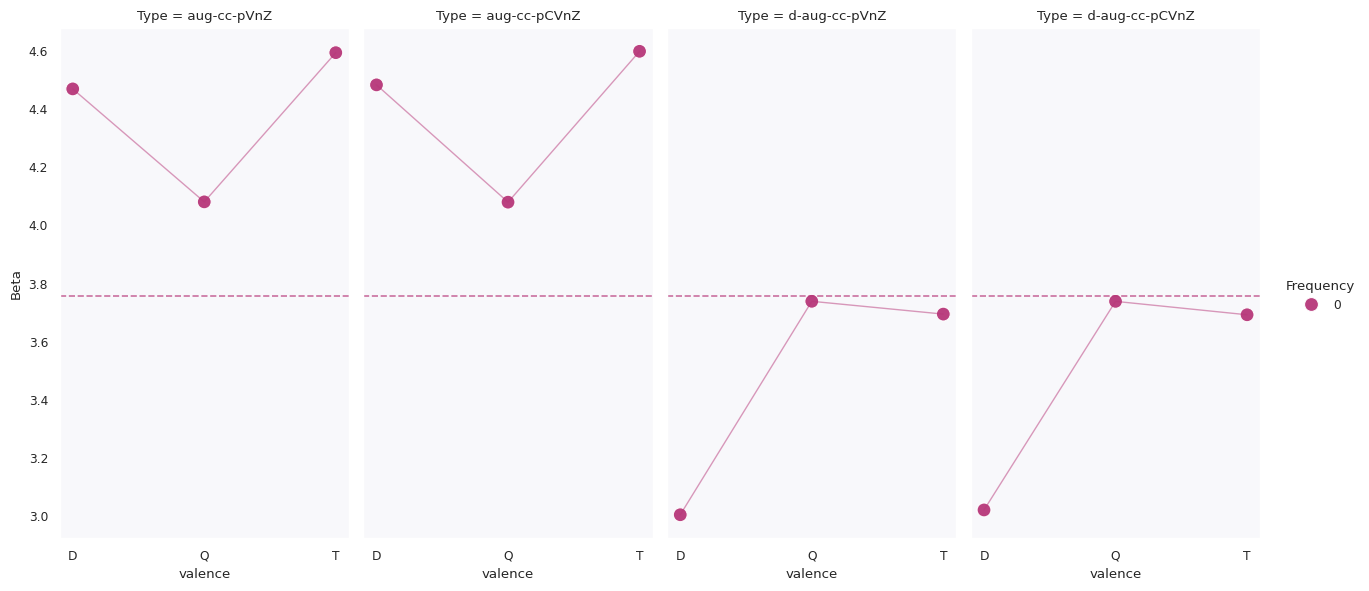

In [59]:

plot_basis_molecule_convergence(beta_hrs_error_df,'HF',['D','T','Q','5'])


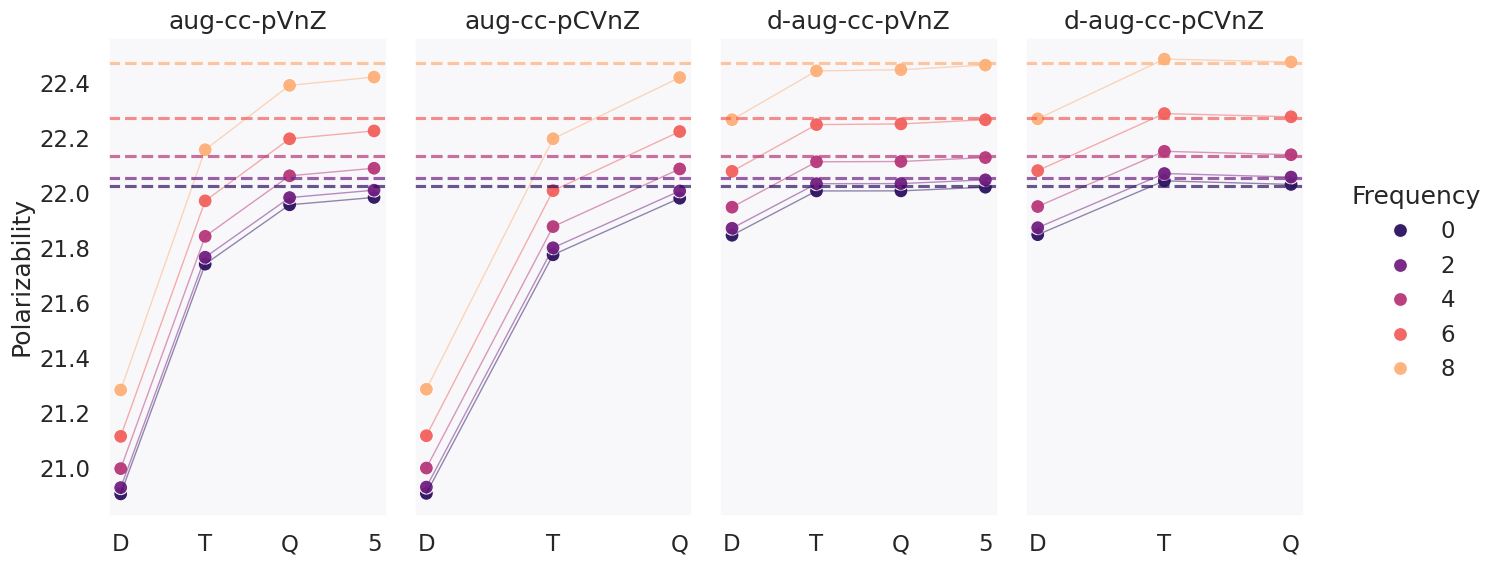

In [240]:

sns.set_context('talk')
sns.set_style('dark')
vlevel = ['D','T','Q',]
basis_labels=['s-D','s-T','s-Q','s-5','s-CD','s-CT','s-CQ','d-D','d-T','d-Q','d-CD','d-CT','d-CQ','d-5']
plot_data = basis_data.query('valence.isin(@vlevel) and molecule.isin(@subset_mols) and omega.isin(@omegas)' ).copy()
# remove unused categories from valence
plot_data.valence = plot_data.valence.cat.remove_unused_categories()
plot_data.omega=plot_data.omega.astype('category')
plot_data.omega = plot_data.omega.cat.remove_unused_categories()
mra_plot_data = mra_data.query('molecule.isin(@subset_mols) and omega.isin(@omegas)').copy()

pal='magma'
# make a facet grid version with seaborn 
g = sns.FacetGrid(data=plot_data, col='Type', sharey=True, sharex=False, height=6,aspect=.5, despine=False)
g.map_dataframe(sns.lineplot, x='valence', y='alpha', hue='omega',  alpha=.5, palette=pal,lw=1,
                legend=True)
g.map_dataframe(sns.scatterplot, x='valence', y='alpha', hue='omega',  alpha=.95, palette=pal,s=100 )
# set the titles
g.set_titles('{col_name}')
# set the ylabels
g.set_ylabels('Polarizability')
# set the xlabels
g.set_xlabels('')




# for each axis in the facet grid add MRA lines 
mra_colors=sns.color_palette(pal, n_colors=len(omegas))
for ax in g.axes.flat:
    for i,om in enumerate(omegas):
        mra_om=mra_plot_data.query('omega==@om')
        ax.axhline(mra_om.alpha.iloc[0], color=mra_colors[i], linestyle='--', label='MRA',alpha=.7)
    ax.patch.set_alpha(0.3)

g.add_legend(title='Frequency', loc='center left', bbox_to_anchor=(1, 0.5))

g.figure.tight_layout()







In [223]:
paper_path=Path('response_paper_figures')



In [227]:
g.savefig(paper_path / 'toc_figure1.png',transparent=False,dpi=1000)

In [239]:

g.savefig(paper_path / 'toc_figure1.svg',transparent=False)
